In [1]:
!git clone 'https://github.com/aakashvardhan/s6-backprop.git'

Cloning into 's6-backprop'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 291 (delta 42), reused 52 (delta 25), pack-reused 222
Receiving objects: 100% (291/291), 754.80 KiB | 6.40 MiB/s, done.
Resolving deltas: 100% (178/178), done.


In [2]:
import sys
sys.path.append('/content/s6-backprop/Part 2')

In [3]:
# Importing torchvision for handling datasets and applying transformations
from torchvision import datasets, transforms

# Importing PyTorch Library
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# Importing python files, including CNN model, train & test the model
from model import Net, model_summary
from utils import train, test, plt_fig

# Import the Matplotlib library for plotting
import matplotlib.pyplot as plt

!pip install torchsummary

In [4]:
# Check if CUDA is available on the system and set `use_cuda` accordingly
use_cuda = torch.cuda.is_available()

# Set the device to "cuda" if CUDA is available, otherwise fall back to using the CPU
device = torch.device("cuda" if use_cuda else "cpu")

# Initialize the model and move it to the specified device (either GPU or CPU)
model = Net().to(device)

In [5]:
model_summary(model)

100%|██████████| 9912422/9912422 [00:00<00:00, 107383052.61it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 94049451.73it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35251527.35it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19262415.34it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Epoch 1


100%|██████████| 10/10 [00:00<00:00, 33.42it/s]


Epoch 2


100%|██████████| 10/10 [00:00<00:00, 29.47it/s]


Epoch 3


100%|██████████| 10/10 [00:00<00:00, 18.69it/s]


Sanity check passed: Model is capable of overfitting to a small subset of the data.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
       BatchNorm2d-2            [-1, 4, 28, 28]               8
           Dropout-3            [-1, 4, 28, 28]               0
         ConvBlock-4            [-1, 4, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             296
       BatchNorm2d-6            [-1, 8, 28, 28]              16
           Dropout-7            [-1, 8, 28, 28]               0
         ConvBlock-8            [-1, 8, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]           1,168
      BatchNorm2d-10           [-1, 16, 28, 28]              32
          Dropout-11           [-1, 16, 28, 28]               0
        ConvBlock-12           [-1, 16, 28, 28]               0
           Conv2d-1

In [6]:
# This block of code is used to define transformations for the training dataset.
train_transforms = transforms.Compose([
    # Randomly applies a center crop of size 22 to the input image with a probability of 0.1.
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    # Resizes the input image to a size of 28x28 pixels.
    transforms.Resize((28, 28)),
    # Randomly rotates the input image within a range of -15 to 15 degrees. The areas left after rotation are filled with 0 (black).
    transforms.RandomRotation((-15., 15.), fill=0),
    # Converts the input image to a PyTorch tensor.
    transforms.ToTensor(),
    # Normalizes the input tensor with a mean of 0.1307 and a standard deviation of 0.3081.
    transforms.Normalize((0.1307,), (0.3081,)),
])

# This block of code is used to define transformations for the testing dataset.
test_transforms = transforms.Compose([
    # Converts the input image to a PyTorch tensor.
    transforms.ToTensor(),
    # Normalizes the input tensor with a mean of 0.1307 and a standard deviation of 0.3081.
    transforms.Normalize((0.1307,), (0.3081,))
])

In [7]:
# MNIST Training dataset with specified transformation
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
# MNIST Testing dataset with specified transformation
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 108874847.12it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 98886280.67it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34681246.44it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17837573.75it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [8]:
# Set the batch size to 512, indicating the number of samples to be processed in one go.
batch_size = 512

# Define a dictionary of keyword arguments for the DataLoader:
# 'batch_size': Specifies the number of samples in each batch.
# 'shuffle': If True, the dataset will be shuffled at the beginning of each epoch to reduce model overfitting.
# 'num_workers': Sets the number of subprocesses to use for data loading. Utilizing multiple workers can enhance data loading throughput.
# 'pin_memory': When set to True and using a CUDA-enabled GPU, this option pins memory, potentially speeding up data transfer to the GPU.
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

# Initialize the DataLoader for the test dataset.
# 'test_data': The dataset to use for testing.
# The DataLoader handles efficient loading of data from 'test_data' using the parameters defined in 'kwargs'.
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

# Initialize the DataLoader for the training dataset.
# 'train_data': The dataset to use for training. The DataLoader will shuffle this data if 'shuffle' is True, as per 'kwargs'.
# This DataLoader facilitates efficient loading of training data, respecting the parameters specified in 'kwargs'.
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

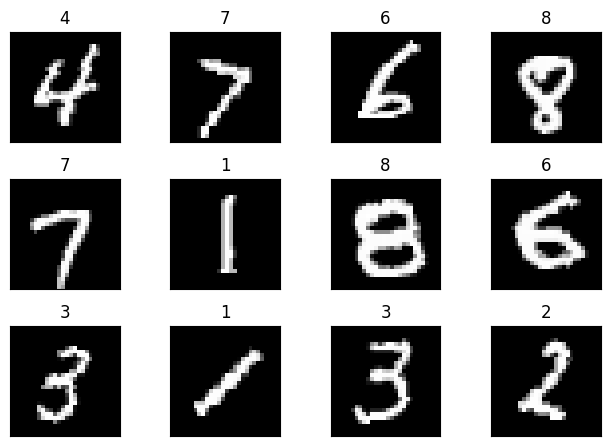

In [9]:
# Retrieve the first batch of data and labels from the training DataLoader
batch_data, batch_label = next(iter(train_loader))

# Initialize a new figure for plotting
fig = plt.figure()

# Loop over the first 12 images and labels in the batch.
for i in range(12):
  # Create a 3x4 grid of subplots. The index of the current subplot (i+1) is set to active
  plt.subplot(3,4,i+1)
  # Adjust the layout to prevent overlapping of subplot elements.
  plt.tight_layout()
  # Display an image. 'squeeze(0)' removes a dimension of size 1, which is common for grayscale images in PyTorch.
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  # Set the title of the subplot to the label of the current image. '.item()' converts a PyTorch scalar to a Python number.
  plt.title(batch_label[i].item())
  # Remove the x-axis ticks.
  plt.xticks([])
  # Remove the y-axis ticks.
  plt.yticks([])

In [10]:
# Initialize the model and move it to the specified device (GPU or CPU)
model = Net().to(device)

# Set up the optimizer for training. Here, we're using Stochastic Gradient Descent (SGD)
# with a learning rate of 0.01 and momentum of 0.9 for better convergence
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# Define a learning rate scheduler that decreases the learning rate by a factor of 0.1
# every 15 epochs to fine-tune the training in later stages
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)


# Specify the number of epochs to train the model
num_epochs = 19

# Start the training loop over the specified number of epochs
for epoch in range(1, num_epochs+1):
  # Print the current epoch number
  print(f'Epoch {epoch}')

  # Call the training function for a single epoch with the training data
  # Pass the model, device, training data loader, optimizer, and loss function as arguments
  train(model, device, train_loader, optimizer,epoch)

  # Evaluate the model with the testing data after training
  # Pass the model, device, testing data loader, and loss function as arguments
  test(model, device, test_loader)

  # Update the learning rate based on the scheduler
  scheduler.step()

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 1


Train: Loss=0.7807 Batch_id=117 Accuracy=39.80: 100%|██████████| 118/118 [00:19<00:00,  6.01it/s]


Test set: Average loss: 0.0029, Accuracy: 5784/10000 (57.84%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 2


Train: Loss=0.2921 Batch_id=117 Accuracy=83.88: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]


Test set: Average loss: 0.0011, Accuracy: 8347/10000 (83.47%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 3


Train: Loss=0.2468 Batch_id=117 Accuracy=91.29: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


Test set: Average loss: 0.0007, Accuracy: 8895/10000 (88.95%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 4


Train: Loss=0.1831 Batch_id=117 Accuracy=93.87: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s]


Test set: Average loss: 0.0002, Accuracy: 9671/10000 (96.71%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 5


Train: Loss=0.1249 Batch_id=117 Accuracy=94.97: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


Test set: Average loss: 0.0004, Accuracy: 9373/10000 (93.73%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 6


Train: Loss=0.1509 Batch_id=117 Accuracy=95.52: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]


Test set: Average loss: 0.0002, Accuracy: 9707/10000 (97.07%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 7


Train: Loss=0.0935 Batch_id=117 Accuracy=95.70: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]


Test set: Average loss: 0.0001, Accuracy: 9778/10000 (97.78%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 8


Train: Loss=0.0745 Batch_id=117 Accuracy=96.43: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]


Test set: Average loss: 0.0002, Accuracy: 9687/10000 (96.87%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 9


Train: Loss=0.1343 Batch_id=117 Accuracy=96.47: 100%|██████████| 118/118 [00:20<00:00,  5.81it/s]


Test set: Average loss: 0.0001, Accuracy: 9812/10000 (98.12%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 10


Train: Loss=0.2031 Batch_id=117 Accuracy=96.69: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


Test set: Average loss: 0.0002, Accuracy: 9733/10000 (97.33%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 11


Train: Loss=0.1253 Batch_id=117 Accuracy=96.88: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


Test set: Average loss: 0.0002, Accuracy: 9776/10000 (97.76%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 12


Train: Loss=0.1009 Batch_id=117 Accuracy=97.07: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


Test set: Average loss: 0.0001, Accuracy: 9794/10000 (97.94%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 13


Train: Loss=0.0465 Batch_id=117 Accuracy=97.06: 100%|██████████| 118/118 [00:20<00:00,  5.67it/s]


Test set: Average loss: 0.0001, Accuracy: 9822/10000 (98.22%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 14


Train: Loss=0.0432 Batch_id=117 Accuracy=97.30: 100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


Test set: Average loss: 0.0001, Accuracy: 9843/10000 (98.43%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 15


Train: Loss=0.1800 Batch_id=117 Accuracy=97.37: 100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


Test set: Average loss: 0.0001, Accuracy: 9815/10000 (98.15%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 16


Train: Loss=0.0175 Batch_id=117 Accuracy=97.92: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]


Test set: Average loss: 0.0001, Accuracy: 9881/10000 (98.81%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 17


Train: Loss=0.0758 Batch_id=117 Accuracy=98.04: 100%|██████████| 118/118 [00:21<00:00,  5.55it/s]


Test set: Average loss: 0.0001, Accuracy: 9879/10000 (98.79%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 18


Train: Loss=0.0792 Batch_id=117 Accuracy=98.02: 100%|██████████| 118/118 [00:21<00:00,  5.62it/s]


Test set: Average loss: 0.0001, Accuracy: 9886/10000 (98.86%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 19


Train: Loss=0.0916 Batch_id=117 Accuracy=98.05: 100%|██████████| 118/118 [00:20<00:00,  5.85it/s]


Test set: Average loss: 0.0001, Accuracy: 9877/10000 (98.77%)

Adjusting learning rate of group 0 to 5.0000e-03.


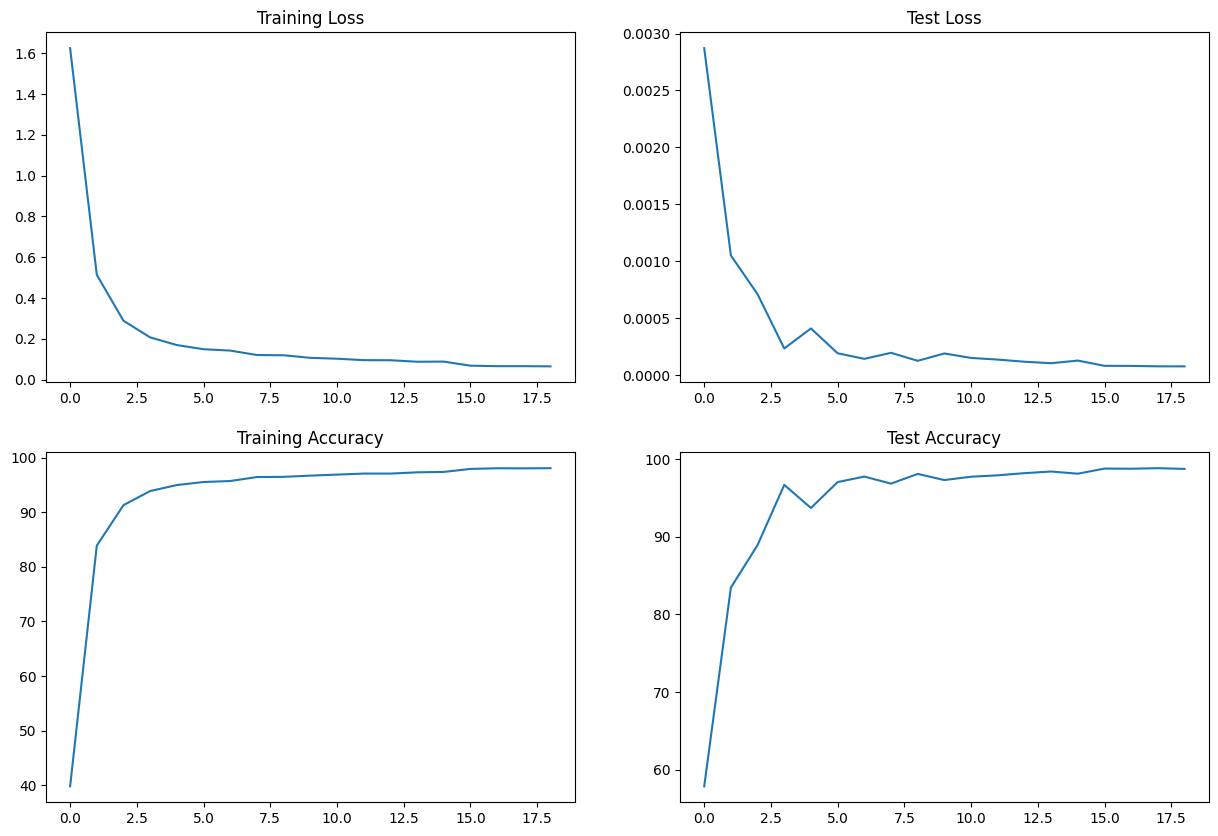

In [11]:
plt_fig()